In [16]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import string
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.stats import multivariate_normal
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm



## Unwrapped functional approximations of scaling laws

In [36]:
def get_init_counts(volume):
        n_ribo = (7.280245377599019e21*(1 + 1.3322199014570686e-12/
            volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
             1.3322199014570686e-12/volume**0.6454883435592754) + 
          1.3525663798553437e-6/volume**0.6454883435592754)

        n_prot = 7.466918335998994e18*(volume**0.6971221467560254)
        
        return n_ribo, n_prot #volume

def get_div_time(volume):
    if True:
        return 1.4881390043125451e-8/volume**0.6454883435592754
    else:
        return 10000.    

## Fixed parameters

In [37]:
# fraction of ribosomal capacity invested in ribosome production
gamma = 0.0138172 #unitless / scales with size

#specific decay rates per second
ribo_decay = 6.205e-6 # 1/s
prot_decay = 6.205e-6 # 1/s




# transcript processing rates [bp/s]
r_R = 50 #bp/s
r_P = 50 #bp/s

# average transcript length 
l_R = 5000 #bp
l_P = 975 #bp


# steady-state
#ribo_decay = gamma * r_R / l_R # 1/s
#prot_decay = (1-gamma)*r_P/ l_P * get_init_counts(1e-18)[0]/get_init_counts(1e-18)[1] # 1/s



LHS = np.array([[1,1,1,0],
               [0,0,0,1]])

RHS = np.array([[2,1,0,0],
                [0,1,0,0]])


#stoichiometric matrix
S = RHS - LHS   




## Define reaction rates by law of mass action

In [38]:
def reaction_rates(volume, X, 
                   mu_ribo_synth= gamma*r_R/l_R, #average kinetic rate of ribosomal synthesis [1/s]
                   mu_prot_synth= (1-gamma)*r_P/l_P, #average kinetic rate of protein synthesis [1/s]
                   mu_ribo_decay= ribo_decay,  #constant decay rate for ribosomes [1/s]
                   mu_prot_decay= prot_decay): #constant decay rate for proteins [1/s]
    
    #vecrtor of rates
    mu_vector = np.array([mu_ribo_synth, mu_prot_synth, mu_ribo_decay, mu_prot_decay])
    scaled_rates = np.power(X.repeat(LHS.shape[1],1),LHS).prod(axis=0)
    #if np.any(scaled_rates < 0):
    #    print(scaled_rates)
    #    print(X)
    #    raise
    return mu_vector * scaled_rates





## Wrap all ordinary differential equations into integrators

In [ ]:

def dZ_dt(state, 
          t=0, #[s]
          volume=1e-18, t_division=1e10): # [m3]
    
    if np.any(np.isnan(state)):
        print(t)
        raise
    
    Z = state.reshape(2*LHS.shape[0]+1, LHS.shape[0])
        
    #expected counts [unitless]
    phi = np.atleast_2d(Z[0]).T 
    
    #compute reaction rates from the function defined above
    F = reaction_rates(volume=volume, X=phi)

    #assert (np.all(np.diag(F) >= 0))
    E = S @ np.sqrt(np.diag(F))
    J = ( (1/phi @ np.atleast_2d(F) ) * LHS).T
    A = S @ J
    
    V = Z[1:A.shape[0]+1]
    G = Z[A.shape[0]+1:]
    
    
    phidot = S @ F
    Vdot = A @ V + V @ A.T + E @ E.T
    
    Gdot = A @ G
    #print(Gdot)


    
    ode_list = np.vstack((phidot, Vdot, Gdot)).reshape(-1)

    
    return ode_list



## Define "Trajectory" class

In [4]:
class Trajectory:
    #functional approximations of scaling laws
    def get_init_counts(self, volume):
        n_ribo = (7.280245377599019e21*(1 + 1.3322199014570686e-12/
            volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
             1.3322199014570686e-12/volume**0.6454883435592754) + 
          1.3525663798553437e-6/volume**0.6454883435592754)

        n_prot = 7.466918335998994e18*(volume**0.6971221467560254)
        
        return n_ribo, n_prot #volume

    def get_div_time(self, volume):
        if True:
            return 1.4881390043125451e-8/volume**0.6454883435592754
        else:
            return 10000.
        
        #n_ribo, n_prot = volume, volume
        #return n_ribo, n_prot

    def __init__(self, 
                 volume   = 1e-18, 
                 iterations=100000, #integrator steps [per generation if Division]
                 final_time=200000, #in case of cell division, how many total steps?
                 cov_scaling = 0.01, #scaling of the initial variances
                 division = True): # cell division?
        
        self.final_time = final_time
        
        self.volume     = volume
        self.iterations = iterations
        self.division = division
        self.cov_scaling = cov_scaling
        
        #set up initial conditions
        
        init_counts = np.array(self.get_init_counts(volume))
        n_species = len(init_counts)
        
        init_cov    = np.eye(n_species) * self.cov_scaling * init_counts**2
        global_init = np.vstack([init_counts.reshape(1,n_species), init_cov, np.identity(n_species)]).astype('float64')
        
        
        # division time in terms of array index
        self.div_time_index = int(self.iterations/self.final_time * self.get_div_time(self.volume))
        
        # from 0 to final_time, 
        T = np.linspace(0, self.final_time, self.iterations)
        #epsilon = self.final_time/self.iterations
        
        
        if self.division:
            n_generations = int(np.ceil(self.final_time/self.get_div_time(self.volume)))

            #divides mean counts by 2 in the beginning of each new generation
            division_matrix = np.vstack((np.ones((1,n_species))*1, np.ones((n_species, n_species))*0.25, np.ones((n_species, n_species))))

            self.generations = []

            for gen_id in range(n_generations):

                #make generations either as long as division time or as the remaining time steps before final_time
                t_final = min(self.get_div_time(self.volume), int(self.final_time - gen_id*self.get_div_time(self.volume)))
                T_gen = np.linspace(0, t_final, self.iterations)

                if gen_id == 0:
                    y0 = global_init.reshape(-1)
                else:
                    #restart counts, divide variance, keep G matrix intact

                    y0 = np.vstack([init_counts.reshape(1, n_species), 
                                    gen[-1, 1:1+n_species, :] / 4 + gen[-1,0,:] / 4,
                                    gen[-1, 1+n_species: , :]]).reshape(-1)


                gen = odeint(dZ_dt, y0=y0, t=T_gen, args=(volume,self.get_div_time(self.volume))).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])
                self.generations.append(gen)

            #stack generations
            solved_odes = np.vstack(self.generations)
        else:
            #only one generation (if no division)
            solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), t=T, args=(volume,self.get_div_time(self.volume))).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])
        
        
        
        #set up state matrices
        
        #means (deterministic behavior)
        self.X_t = solved_odes[:,0,:]
        
        #covariance matrix over time
        self.V_t = solved_odes[:,1:n_species+1,:]
        
        #across-time variance-covariance
        self.G_t = solved_odes[:,n_species+1:, :]
        self.cov_t = self.V_t[0] @ self.G_t.transpose(0,2,1)

        #ribosomal variance at time t
        self.var_ribo = self.V_t[:,0,0]
        #protein variance at time t
        self.var_prot = self.V_t[:,1,1]
        #ribosome-protein covariance at time t
        self.cov_riboprot = self.V_t[:,0,1]

        #covariance of ribosome t(0) vs ribosomes at t(t)
        self.cov_ribo_over_time = self.cov_t[:,0,0]
        #covariance of proteins t(0) vs ribosomes at t(t)
        self.cov_prot_over_time = self.cov_t[:,1,1]
        #covariance of state at t(0) vs state at t(t)
        self.cov_riboprot_over_time = self.cov_t[:,1,0]

        #pierson correlations
        self.rho_ribo = np.array([self.cov_ribo_over_time[t]/(np.sqrt(self.var_ribo[0])*np.sqrt(self.var_ribo[t])) for t in range(0,iterations)])
        self.rho_prot = np.array([self.cov_prot_over_time[t]/(np.sqrt(self.var_prot[0])*np.sqrt(self.var_prot[t])) for t in range(0,iterations)])
        self.rho_riboprot = np.array([self.cov_riboprot_over_time[t]/(np.sqrt(self.cov_riboprot[0])*np.sqrt(self.cov_riboprot[t])) for t in range(0,iterations)])
        
        
        #mutual information either with taylor series or without
        if any(self.rho_ribo < 1e-3):
            self.mi_ribo = 0.721348*self.rho_ribo**2
            
        else:    
            self.mi_ribo = -0.5*np.log2(1-self.rho_ribo**2)
        
        if any(self.rho_prot < 1e-3):
            self.mi_prot = 0.721348*self.rho_prot**2
        else:    
            self.mi_prot = -0.5*np.log2(1-self.rho_riboprot**2) 
        
        if any(self.rho_riboprot < 1e-3):
            self.mi_riboprot = 0.721348*self.rho_riboprot**2
        else:    
            self.mi_riboprot = -0.5*np.log2(1-self.rho_riboprot**2) 
                
                
        #try to calculate MI at division time more accurately, if not possible then Taylor approximate it        
        if self.rho_ribo[self.div_time_index] < 1e-3:
            self.mi_ribo_div = 0.721348*self.rho_ribo[self.div_time_index]**2
        elif self.rho_ribo[self.div_time_index] > 1-1e-3:
            self.mi_ribo_div = -0.5*np.log2(1-self.rho_ribo[self.div_time_index]**2)
        else:
            self.mi_ribo_div = -0.5*np.log2(1-self.rho_ribo[self.div_time_index]**2)
        
        if self.rho_prot[self.div_time_index] < 1e-3:
            self.mi_prot_div = 0.721348*self.rho_prot[self.div_time_index]**2
        else:
            self.mi_prot_div = -0.5*np.log2(1-self.rho_prot[self.div_time_index]**2)
        
        
        if self.rho_riboprot[self.div_time_index] < 1e-3:
            self.mi_riboprot_div = 0.721348*self.rho_riboprot[self.div_time_index]**2
        else:
            self.mi_riboprot_div = -0.5*np.log2(1-self.rho_riboprot[self.div_time_index]**2)
        
        
        #wrap contour method
    def contour(self, ax=None, fractions=10):
        
        
        index_correction = np.zeros(fractions)
        index_correction[-1] = -1
        indices = (np.linspace(0,1,fractions) * self.iterations + index_correction).astype('int')

        ax = ax or plt.gca()
        ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        #fig, ax = plt.subplots(1, figsize=(10,10))

        x_contour = np.linspace(np.min(self.X_t[:,0])*0.9,np.max(self.X_t[:,0])*1.1,100)
        y_contour = np.linspace(np.min(self.X_t[:,1])*0.9,np.max(self.X_t[:,1])*1.1,100)
        x_contour, y_contour = np.meshgrid(x_contour, y_contour)
        points_contour = np.stack((x_contour, y_contour), axis=-1)


        z_contours = [multivariate_normal(mean=self.X_t[i], cov=self.V_t[i]).pdf(points_contour) for i in indices] 

        
        for i,z in enumerate(z_contours):
            ax.contour(x_contour, y_contour, z)
            #print(self.X_t[indices[i]])
            ax.annotate('t = {} s'.format("{:,.0f}" .format(self.get_div_time(self.volume)*indices[i]/self.iterations) ),self.X_t[indices[i]] +  np.array([-0.1,0.2]) * self.X_t[0,:] , size=15, ha='center')
            #ax.annotate('t = {}'.format("{:.2}".format(self.get_div_time(self.volume)*indices[i]/1e6) ),self.X_t[indices[i]]*np.array([0.95,1.2]), size=15)

        ax.set_xlabel('Number of ribosomes', size=25)
        ax.set_ylabel('Number of proteins', size=25)
        ax.set_xlim([np.min(self.X_t[:,0])*0.75,np.max(self.X_t[:,0])*1.1])
        ax.set_ylim([np.min(self.X_t[:,1])*0.9,np.max(self.X_t[:,1])*1.15])

        return ax



## Divergence in variance despite division

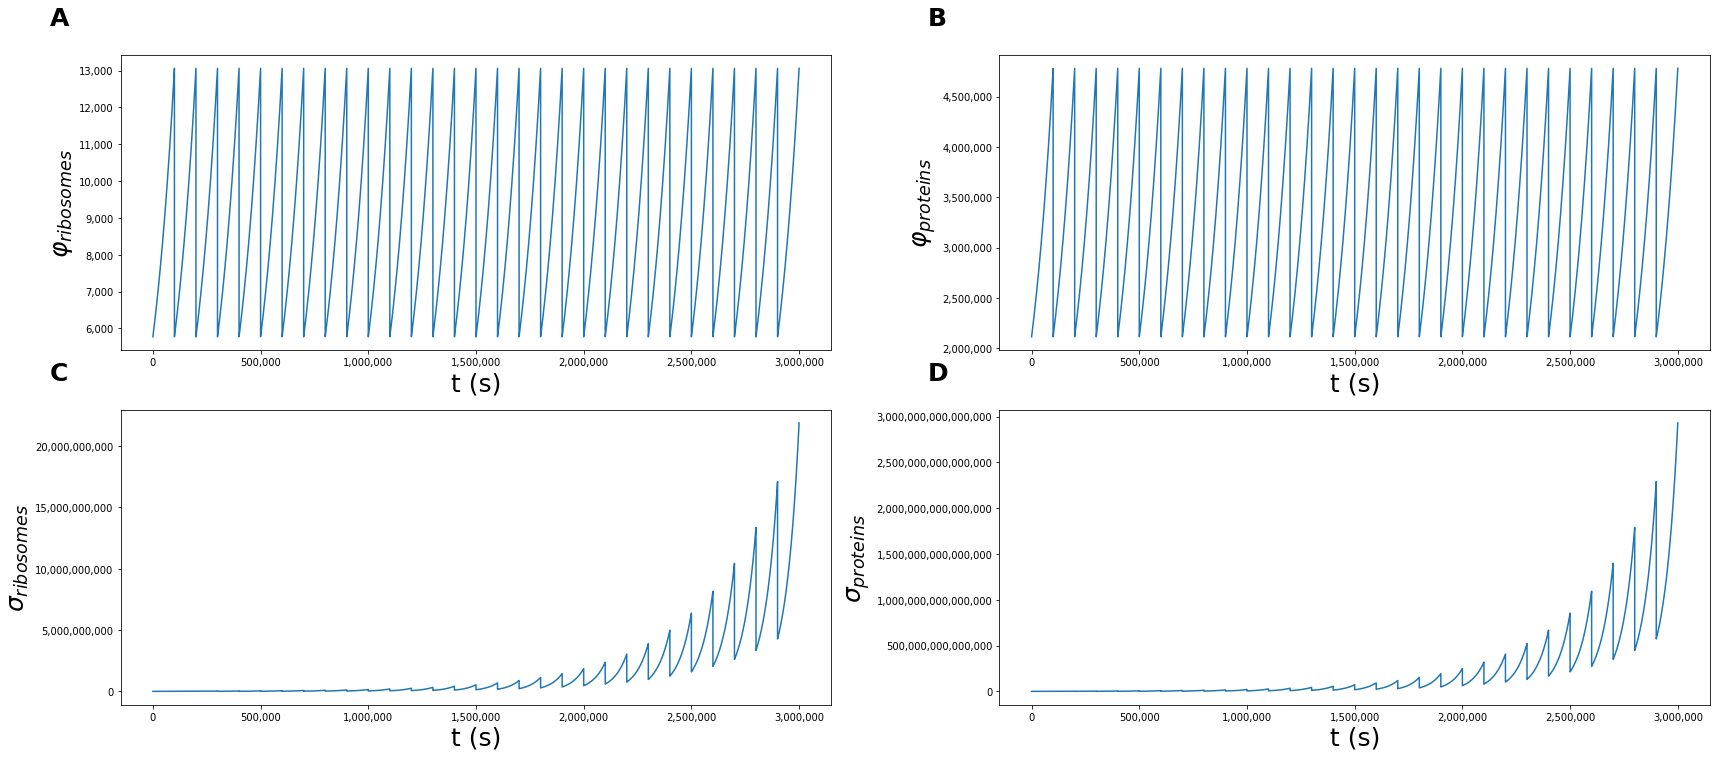

In [18]:
traj = Trajectory(volume=1e-18, division=True, final_time=500000, cov_scaling=1e-1)


range_end = 3000000

fig, axes = plt.subplots(2,2, figsize=(24,10))



axes[0,0].plot(range(range_end),traj.X_t[0:range_end,0])
axes[0,0].set_ylabel(r'$\varphi_{ribosomes}$', size=25)
axes[0,0].set_xlabel(r't (s)',size=25)
#axes[0,0].set_yscale('log')

axes[0,1].plot(range(range_end),traj.X_t[0:range_end,1])
axes[0,1].set_ylabel(r'$\varphi_{proteins}$', size=25)
axes[0,1].set_xlabel(r't (s)',size=25)
#axes[0,1].set_yscale('log')

axes[1,0].plot(range(range_end),traj.V_t[0:range_end,0,0])
axes[1,0].set_ylabel(r'$\sigma_{ribosomes}$', size=25)
axes[1,0].set_xlabel(r't (s)',size=25)
#axes[1,0].set_yscale('log')

axes[1,1].plot(range(range_end),traj.V_t[0:range_end,1,1])
axes[1,1].set_ylabel(r'$\sigma_{proteins}$', size=25)
axes[1,1].set_xlabel(r't (s)',size=25)
#axes[1,1].set_yscale('log')


for n,ax in enumerate(axes.ravel()):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=25, weight='bold')
    ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))



plt.tight_layout()
plt.show()

In [10]:
volumes = np.logspace(-20,-15,20)
trajectories_by_volume = [Trajectory(volume=v, division=False) for v in volumes]

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log2


## Heatmaps

In [11]:
matrix_length = 40

volumes = np.logspace(-20,-15,matrix_length)
scaling_factors = np.logspace(-10,10,matrix_length)
ribo_matrix = np.zeros((matrix_length,matrix_length))
prot_matrix = np.zeros((matrix_length,matrix_length))
traj_matrix = np.zeros((matrix_length,matrix_length)).astype('object')

for i,f in enumerate(scaling_factors):
    for j,v in enumerate(volumes):
        traj_ij = Trajectory(volume=v, division=False, cov_scaling=f)
        traj_matrix[i,j] = traj_ij
        ribo_matrix[i,j] = traj_ij.mi_ribo_div
        prot_matrix[i,j] = traj_ij.mi_prot_div

        
#debug nans and infinities by replacing with neighboring values
singularities = np.array(np.where(np.isnan(ribo_matrix))).T
for i in singularities:
    if not traj_matrix[tuple(i)].mi_ribo[traj_matrix[tuple(i)].div_time_index] < 1000: #is it NAN or INF?
        halt_counter = 1
        mi_ribo_candidate = traj_matrix[tuple(i)].mi_ribo[traj_matrix[tuple(i)].div_time_index]
        
        while ((halt_counter < 25) and (not mi_ribo_candidate < 1000)):
            halt_counter+=1
            mi_ribo_candidate = traj_matrix[tuple(i)].mi_ribo[traj_matrix[tuple(i)].div_time_index+halt_counter]
        
        traj_matrix[tuple(i)].mi_ribo_div = mi_ribo_candidate
        ribo_matrix[tuple(i)] = mi_ribo_candidate
            

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in log2


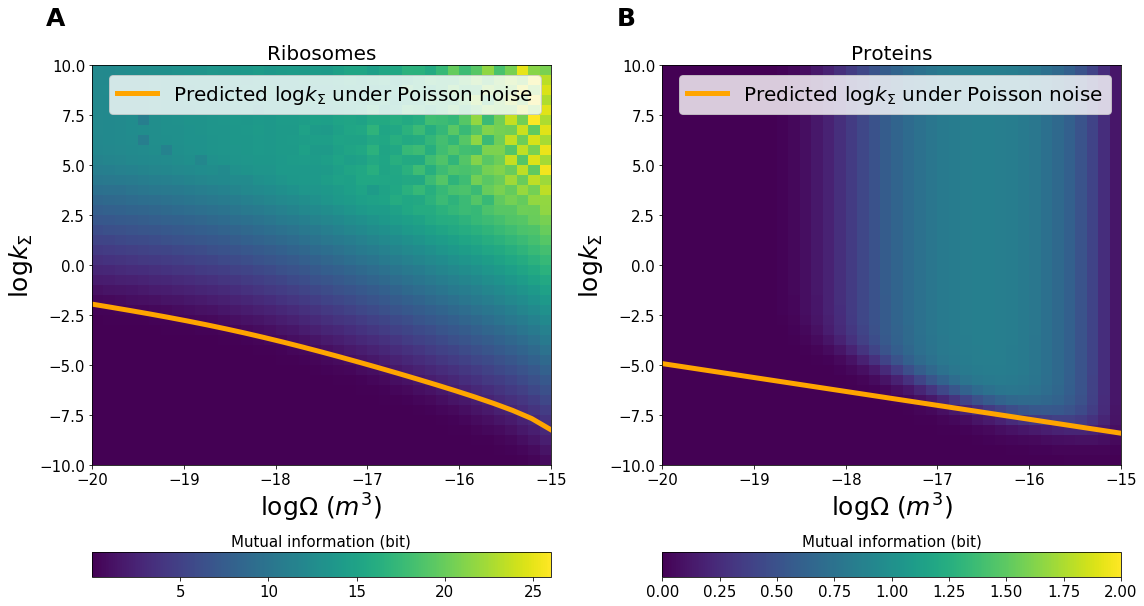

In [22]:
cell_logspace = np.logspace(-20,-15,25)
cell_linspace = np.linspace(-20,-15,25)
ribo_scales, prot_scales = np.vectorize(get_init_counts)(cell_logspace)


#translate imshow function to the true values shown in the ticks
extent = [np.log10(volumes[0]),np.log10(volumes[-1]),
          np.log10(scaling_factors[0]), np.log10(scaling_factors[-1])]


fig, axes = plt.subplots(2,2, figsize=(16,8),
                        gridspec_kw = {'height_ratios':[16, 1]})


ribo_hm = axes[0,0].imshow(ribo_matrix, origin='lower', extent=extent, aspect='auto')#, norm=LogNorm(), vmin=1e-1, vmax=18)
prot_hm = axes[0,1].imshow(prot_matrix, origin='lower', extent=extent, aspect='auto', cmap='viridis', vmax=2)#, norm=LogNorm(), vmin=1e-1, vmax=1)

axes[0,0].set_title('Ribosomes', size=20)
axes[0,1].set_title('Proteins', size=20)

for ax in axes.ravel():
    ax.tick_params(labelsize=15)

axes[0,0].set_xlabel(r'$\log{\Omega}$ $(m^3)$', size=25)
axes[0,1].set_xlabel(r'$\log{\Omega}$ $(m^3)$', size=25)

axes[0,0].set_ylabel(r'$\log{k_{\Sigma}}$', size=25)
axes[0,1].set_ylabel(r'$\log{k_{\Sigma}}$', size=25)

axes[0,0].plot(cell_linspace, np.log10(1/ribo_scales), label=r'Predicted $\log k_{\Sigma}$ under Poisson noise', lw=5, c='orange')
axes[0,1].plot(cell_linspace, np.log10(1/prot_scales), label=r'Predicted $\log k_{\Sigma}$ under Poisson noise', lw=5, c='orange')

cb_ribo = plt.colorbar(ribo_hm, axes[1,0], orientation='horizontal')
cb_prot = plt.colorbar(prot_hm, axes[1,1], orientation='horizontal')

cb_ribo.ax.set_title('Mutual information (bit)',size=15)
cb_prot.ax.set_title('Mutual information (bit)',size=15)
axes[0,0].legend(fontsize=20)
axes[0,1].legend(fontsize=20)


axes[0,0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0,0].transAxes, 
        size=25, weight='bold')

axes[0,1].text(-0.1, 1.1, string.ascii_uppercase[1], transform=axes[0,1].transAxes, 
            size=25, weight='bold')
   

plt.tight_layout()
plt.show()

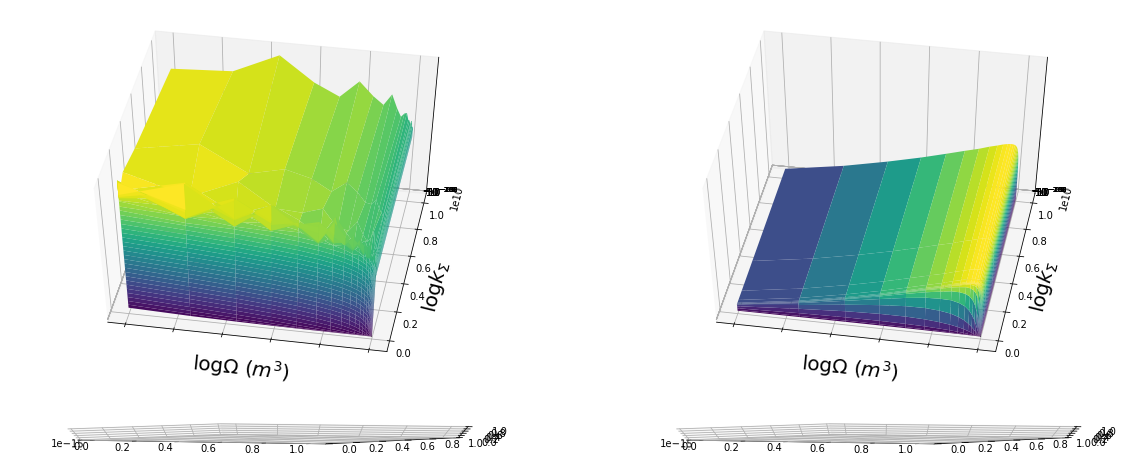

In [14]:
#traj_matrix[39,37].mi_ribo_div
fig, axes = plt.subplots(2,2, figsize=(20,8),sharex=True,
subplot_kw=dict(projection='3d'), gridspec_kw = {'height_ratios':[16, 1]})

vv, ff = np.meshgrid(volumes, scaling_factors)

axes[0,0].plot_surface(vv, ff, ribo_matrix, cmap='viridis')
axes[0,1].plot_surface(vv, ff, prot_matrix, cmap='viridis')

axes[0,0].set_xlabel(r'$\log{\Omega}$ $(m^3)$', size=20)
axes[0,1].set_xlabel(r'$\log{\Omega}$ $(m^3)$', size=20)

axes[0,0].set_ylabel(r'$\log{k_{\Sigma}}$', size=20)
axes[0,1].set_ylabel(r'$\log{k_{\Sigma}}$', size=20)

axes[0,0].set_zscale('log')
axes[0,1].set_zscale('log')

axes[0,0].set_zlim([0,25])
axes[0,1].set_zlim([0,2])

axes[0,0].invert_yaxis()
axes[0,1].invert_yaxis()

axes[0,0].view_init(50,100)
axes[0,1].view_init(50,100)

plt.show()

## Mutual information vs cell size

In [23]:
volumes = np.logspace(-20,-15,20)
trajectories_by_volume = [Trajectory(volume=v, division=False) for v in volumes]

mi_ribo_div_by_size = [trajectories_by_volume[i].mi_ribo_div for i in range(len(volumes))]
mi_prot_div_by_size = [trajectories_by_volume[i].mi_prot_div for i in range(len(volumes))]
mi_riboprot_div_by_size = [trajectories_by_volume[i].mi_riboprot_div for i in range(len(volumes))]

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in less
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log2


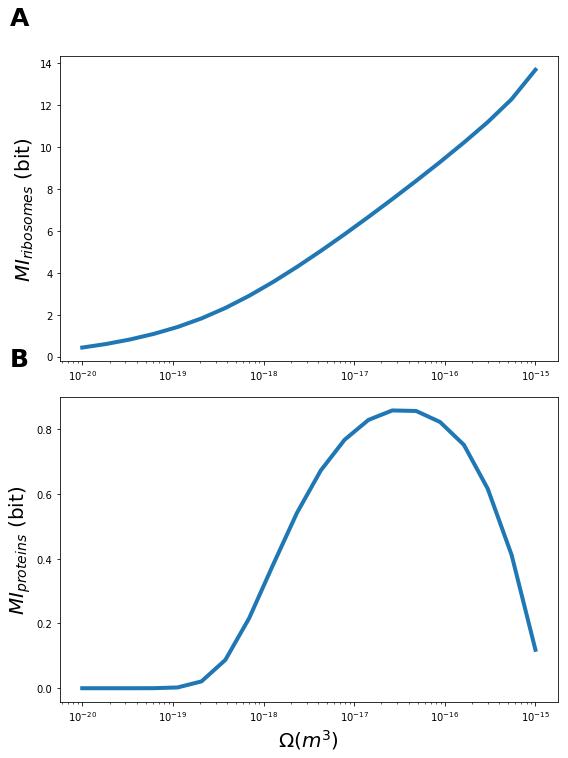

In [35]:
fig, axes = plt.subplots(2, sharex=False, figsize=(8,10))
axes[0].plot(volumes,mi_ribo_div_by_size,lw=4)
axes[0].set_xscale('log')
axes[1].plot(volumes,mi_prot_div_by_size, lw=4)
axes[1].set_xscale('log')
#axes[2].plot(volumes,mi_riboprot_div_by_size)
axes[1].set_xscale('log')
axes[1].set_xlabel(r'$\Omega (m^3)$', size=20)
axes[0].set_ylabel(r'$MI_{ribosomes}$ (bit)', size=20)
axes[1].set_ylabel(r'$MI_{proteins}$ (bit)', size=20)
#axes[0].set_title('', size=20)

axes[0].text(-0.1, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes, 
        size=25, weight='bold')

axes[1].text(-0.1, 1.1, string.ascii_uppercase[1], transform=axes[1].transAxes, 
            size=25, weight='bold')




plt.tight_layout()
plt.show()

## Appendix B: Scaling laws in initial counts

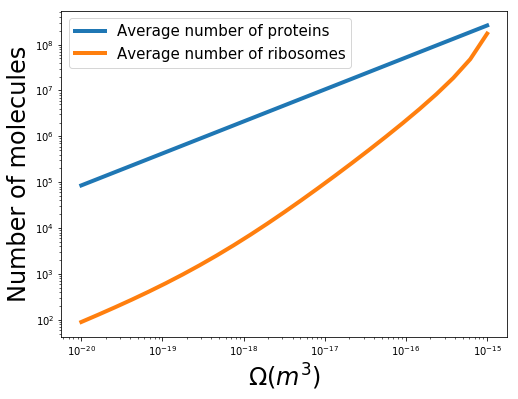

In [34]:
cell_logspace = np.logspace(-20,-15,25)
ribo_scales, prot_scales = np.vectorize(get_init_counts)(cell_logspace)

fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(cell_logspace,prot_scales, label='Average number of proteins', lw=4)
ax.plot(cell_logspace,ribo_scales, label='Average number of ribosomes', lw=4)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'$\Omega (m^3$)', size=24)
ax.set_ylabel(r'Number of molecules', size=24)



# axes[1].plot(cell_logspace,prot_scales)
# axes[1].set_yscale('log')
# axes[1].set_xscale('log')

plt.legend(fontsize=15)



plt.show()